
**Film Junky Union - Categorizing Movie Reviews**
---


### Introduction
---
This project aimed to analyze and predict the polarity of movie reviews using three models: BERT, Bag of Words (BOW), and TF-IDF. The analysis began with comprehensive data preprocessing—removing unnecessary columns, handling missing values, and eliminating duplicates—to ensure a clean dataset for modeling. The exploratory data analysis revealed key patterns in review ratings and polarity distribution, highlighting trends in sentiment over time. Each model was evaluated using both the original dataset and a custom set of 40 new reviews. Among the three, the TF-IDF model demonstrated the best overall performance, achieving the highest F1 score on both the test set and the new reviews (0.88 and 0.93, respectively), while also maintaining a strong balance between precision and recall. Consequently, TF-IDF appears to be the most effective choice for this sentiment classification task.


### Importing Libraries
---

In [95]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import matplotlib as mpl
from catboost import CatBoostClassifier
import transformers
from transformers import BertConfig, BertModel
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import random
from joblib import dump
from joblib import load
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import os
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import warnings

In [93]:
warnings.filterwarnings("ignore")


### Importing Dataset and EDA
---

In [12]:
df_reviews = pd.read_csv('\imdb_reviews.tsv', sep="\t"')

In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [14]:
df_reviews.head(3)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489


In [15]:
df_reviews = df_reviews.drop(['tconst','genres','average_rating','title_type','primary_title','original_title','end_year'
                              ,'runtime_minutes','is_adult','votes','sp','idx'],axis=1)

In [16]:
df_reviews

,start_year,review,rating,pos,ds_part
0,1971,The pakage implies that Warren Beatty and Gold...,1,0,train
1,1971,How the hell did they get this made?! Presenti...,1,0,train
2,2002,There is no real story the film seems more lik...,3,0,test
3,2002,Um .... a serious film about troubled teens in...,7,1,test
4,2002,I'm totally agree with GarryJohal from Singapo...,9,1,test
...,...,...,...,...,...
47326,1972,This is another of my favorite Columbos. It sp...,10,1,test
47327,1996,Talk about being boring! I got this expecting ...,4,0,test
47328,1996,"I never thought I'd say this about a biopic, b...",8,1,test
47329,1996,Spirit and Chaos is an artistic biopic of Miya...,9,1,test


In [17]:
df_reviews.isna().sum()

start_year    0
review        0
rating        0
pos           0
ds_part       0
dtype: int64

In [18]:
df_reviews = df_reviews.dropna().reset_index(drop=True)

In [19]:
df_reviews.isna().sum()

start_year    0
review        0
rating        0
pos           0
ds_part       0
dtype: int64

In [20]:
df_reviews.duplicated().sum()

85

In [21]:
df_reviews['review'] = df_reviews['review'].str.strip().str.lower()

In [22]:
df_reviews = df_reviews.drop_duplicates().reset_index(drop=True)

In [23]:
df_reviews['review'].duplicated().sum()

6

In [24]:
print((df_reviews['review'] == '').sum())  
print((df_reviews['review'] == ' ').sum())  
print((df_reviews['review'] == 'nan').sum())
print((df_reviews['review'] == 'NaN').sum())

0
0
0
0


In [25]:
duplicate_rows = df_reviews[df_reviews['review'].duplicated(keep=False)]
print(duplicate_rows)

       start_year                                             review  rating  \
1751         1984  i used to watch this show when i was a little ...       9   
5809         1980  sondra locke stinks in this film, but then she...       3   
5810         1980  sondra locke stinks in this film, but then she...       4   
23807        1989  i used to watch this show when i was a little ...       9   
34416        1943  there has been a political documentary, of rec...       8   
34497        1971  another well done moral ambiguity pieces where...       7   
34499        1971  another well done moral ambiguity pieces where...       8   
39962        1943  there has been a political documentary, of rec...       8   
43788        2005  ah yet another seagal movie.in no less than a ...       2   
43796        2005  ah yet another seagal movie.in no less than a ...       3   
44457        2005  the whole shorthand for supposedly being more ...       8   
44466        2005  the whole shorthand f

In [26]:
rows_to_drop = [1751, 5809, 5810, 23807, 34416, 34497, 34499, 39962, 43788, 43796, 44457, 44466]
df_reviews = df_reviews.drop(index=rows_to_drop).reset_index(drop=True)

In [27]:
df_reviews['review'].duplicated().sum()

0

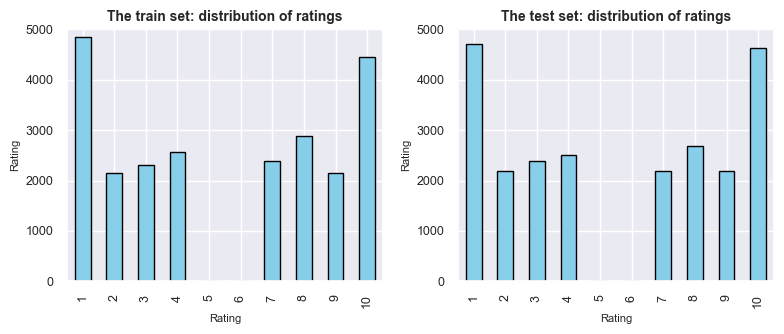

In [41]:
sns.set_theme(style="darkgrid", palette="Blues_d")

mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))

dft = df_reviews.query('ds_part == "train"')["rating"].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
ax = axs[0]
dft.plot.bar(ax=ax, color="skyblue", edgecolor="black")
ax.set_ylim([0, 5000])
ax.set_ylabel("Rating", fontsize=8)
ax.set_xlabel("Rating", fontsize=8)
ax.set_title("The train set: distribution of ratings", fontweight='bold', fontsize=10)
ax.tick_params(axis='both', labelsize=9)

dft = df_reviews.query('ds_part == "test"')["rating"].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
ax = axs[1]
dft.plot.bar(ax=ax, color="skyblue", edgecolor="black")
ax.set_ylim([0, 5000])
ax.set_ylabel("Rating", fontsize=8)
ax.set_xlabel("Rating", fontsize=8)
ax.set_title("The test set: distribution of ratings", fontweight='bold', fontsize=10)
ax.tick_params(axis='both', labelsize=9)

fig.tight_layout()
plt.show()
plt.close('all')

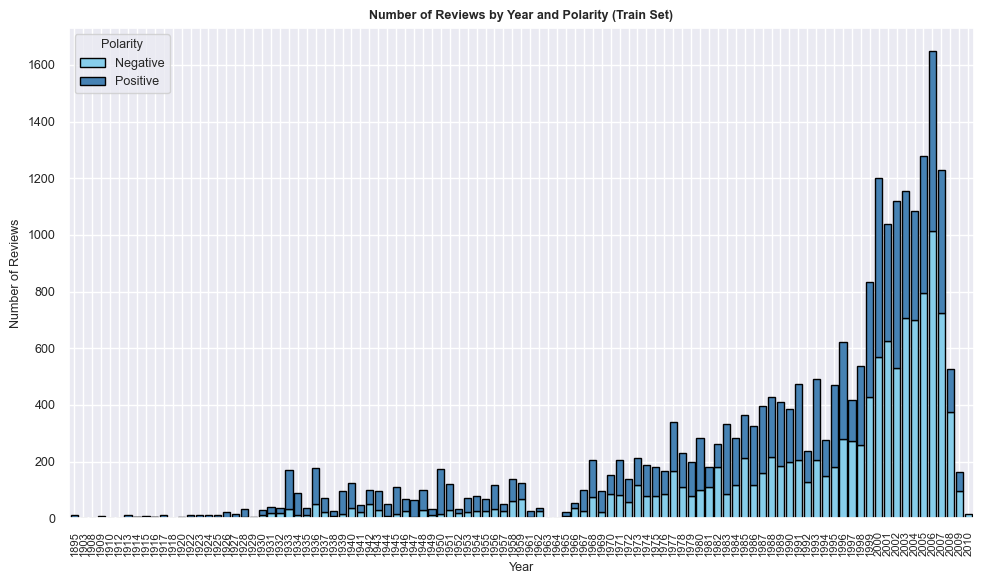

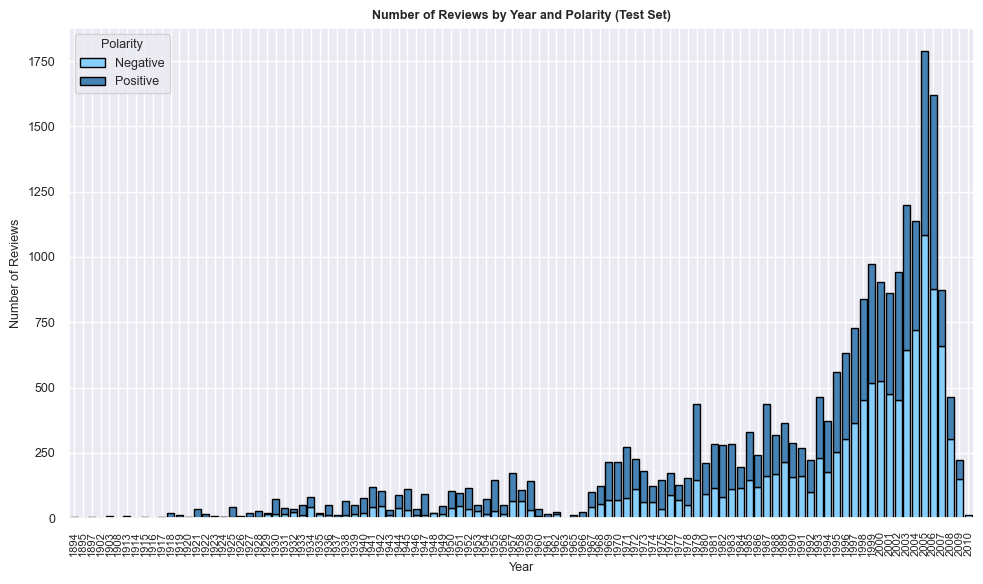

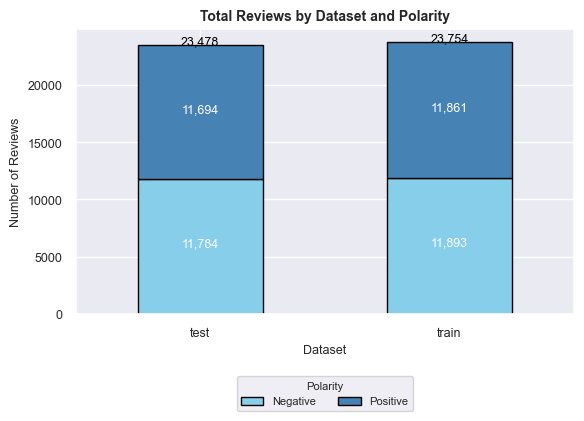

In [58]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Bitstream Vera Sans"]

sns.set_theme(style="darkgrid")

df_train = df_reviews[df_reviews['ds_part'] == 'train']

dft = df_train.groupby(['start_year', 'pos'])['pos'].count().unstack(fill_value=0)

dft.columns = ["Negative", "Positive"]

fig, ax = plt.subplots(figsize=(10, 6))

dft.plot(kind="bar", stacked=True, color=["skyblue", "steelblue"], edgecolor="black", width=0.8, ax=ax)

ax.set_title("Number of Reviews by Year and Polarity (Train Set)", fontsize=9,fontweight='bold')
ax.set_xlabel("Year", fontsize=9)
ax.set_ylabel("Number of Reviews", fontsize=9)
ax.tick_params(axis='x', labelsize=8, rotation=90)
ax.tick_params(axis='y', labelsize=9)
ax.legend(title="Polarity", fontsize=9, title_fontsize=9)

plt.tight_layout()
plt.show()

sns.set_theme(style="darkgrid")

df_train = df_reviews[df_reviews['ds_part'] == 'test']

dft = df_train.groupby(['start_year', 'pos'])['pos'].count().unstack(fill_value=0)

dft.columns = ["Negative", "Positive"]

fig, ax = plt.subplots(figsize=(10, 6))

dft.plot(kind="bar", stacked=True, color=["lightskyblue", "steelblue"], edgecolor="black", width=0.8, ax=ax)

ax.set_title("Number of Reviews by Year and Polarity (Test Set)", fontsize=9,fontweight='bold')
ax.set_xlabel("Year", fontsize=9)
ax.set_ylabel("Number of Reviews", fontsize=9)
ax.tick_params(axis='x', labelsize=8, rotation=90)
ax.tick_params(axis='y', labelsize=9)
ax.legend(title="Polarity", fontsize=9, title_fontsize=9)

plt.tight_layout()
plt.show()

sns.set_theme(style="darkgrid")

df_grouped = df_reviews.groupby(['ds_part', 'pos'])['pos'].count().unstack(fill_value=0)
df_grouped.columns = ["Negative", "Positive"]

fig, ax = plt.subplots(figsize=(6, 4.5))
df_grouped.plot(kind="bar", stacked=True, color=["skyblue", "steelblue"], edgecolor="black", ax=ax)

for index, (negative, positive) in enumerate(zip(df_grouped["Negative"], df_grouped["Positive"])):
    total = negative + positive
    ax.text(index, total + 50, f"{int(total):,}", ha='center', fontsize=9, color='black')

for index, negative in enumerate(df_grouped["Negative"]):
    ax.text(index, negative / 2, f"{int(negative):,}", ha='center', fontsize=9, color='white')

for index, positive in enumerate(df_grouped["Positive"]):
    neg_value = df_grouped["Negative"].iloc[index]
    ax.text(index, neg_value + (positive / 2), f"{int(positive):,}", ha='center', fontsize=9, color='white')

ax.set_title("Total Reviews by Dataset and Polarity", fontsize=10, fontweight='bold')
ax.set_xlabel("Dataset", fontsize=9)
ax.set_ylabel("Number of Reviews", fontsize=9)
ax.tick_params(axis='x', labelsize=9, rotation=0)
ax.tick_params(axis='y', labelsize=9)

ax.legend(title="Polarity", fontsize=8, title_fontsize=8,
          loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.tight_layout()
plt.show()

The exploratory data analysis began by removing columns deemed unnecessary for further analysis of the movie reviews. The remaining columns included start_year, review, rating, pos, and ds_part. The dataset was then checked for null values, and any identified were minimal and subsequently removed. Duplicates across the dataset, particularly in the review column (which would later be used for polarity prediction), were identified and eliminated. After these steps, no further missing values were found.

With the dataset preprocessed, visualizations were created to gain deeper insights. Both the training and test datasets displayed a similar distribution of ratings, with a higher concentration at the extremes (1 and 10). Notably, no ratings were observed in the middle range (5 or 6), meaning the distributions were skewed toward 1–4 and 7–10. Additionally, the number of reviews by polarity (0 or 1) and by dataset (train and test) revealed an increasing trend in the number of negative reviews over the years. In recent years, negative reviews have outnumbered positive ones, reversing the trend observed in earlier periods.

However, when evaluating class balance across all years, the total distribution of polarity between the train and test sets appears balanced. For instance, the test set contained 23,478 reviews, comprising 11,694 positive and 11,784 negative reviews. Similarly, the train set included 23,754 reviews, with 11,861 positive and 11,893 negative reviews. This indicates that while a slight class imbalance might emerge depending on the time window analyzed, the overall distribution across all years shows negligible imbalance. This consolidated view suggests that class imbalance is unlikely to significantly affect the performance of a classification model.

### Model Training
---


#### BERT Model

In [60]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

In [61]:
train_reviews = df_reviews[df_reviews['ds_part'] == 'train']
random_train_reviews = train_reviews['review'].iloc[:100]

test_reviews = df_reviews[df_reviews['ds_part'] == 'test']
random_test_reviews = test_reviews['review'].iloc[:100]

max_length = 512
batch_size = 50

ids_list_train = []
attention_mask_list_train = []

for input_text in random_train_reviews[:100]:
    ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
    padded = np.array(ids + [0] * (max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list_train.append(padded)
    attention_mask_list_train.append(attention_mask)

ids_array = np.array(ids_list_train)
attention_mask_array = np.array(attention_mask_list_train)

embeddings_train = []

for i in tqdm(range((len(ids_array) + batch_size - 1) // batch_size)):  
    ids_batch = torch.tensor(ids_array[batch_size * i : batch_size * (i + 1)], dtype=torch.long)
    attention_mask_batch = torch.tensor(attention_mask_array[batch_size * i : batch_size * (i + 1)], dtype=torch.long)
    with torch.no_grad():
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)
    embeddings_train.append(batch_embeddings[0][:, 0, :].numpy())
    
ids_list_test = []
attention_mask_list_test = []

for input_text in random_test_reviews[:100]:
    ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
    padded = np.array(ids + [0] * (max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list_test.append(padded)
    attention_mask_list_test.append(attention_mask)

ids_array = np.array(ids_list_test)
attention_mask_array = np.array(attention_mask_list_test)

embeddings_test = []

for i in tqdm(range((len(ids_array) + batch_size - 1) // batch_size)):  
    ids_batch = torch.tensor(ids_array[batch_size * i : batch_size * (i + 1)], dtype=torch.long)
    attention_mask_batch = torch.tensor(attention_mask_array[batch_size * i : batch_size * (i + 1)], dtype=torch.long)
    with torch.no_grad():
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)
    embeddings_test.append(batch_embeddings[0][:, 0, :].numpy())


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:40<00:00, 50.16s/it]


F1 Score Train: 1.00
F1 Score Test: 0.88

Threshold = 0.00 | Precision = 0.500, Recall = 1.000, F1 = 0.667
Threshold = 0.10 | Precision = 0.595, Recall = 1.000, F1 = 0.746
Threshold = 0.20 | Precision = 0.649, Recall = 1.000, F1 = 0.787
Threshold = 0.30 | Precision = 0.746, Recall = 1.000, F1 = 0.855
Threshold = 0.40 | Precision = 0.821, Recall = 0.920, F1 = 0.868
Threshold = 0.50 | Precision = 0.865, Recall = 0.900, F1 = 0.882
Threshold = 0.60 | Precision = 0.863, Recall = 0.880, F1 = 0.871
Threshold = 0.70 | Precision = 0.891, Recall = 0.820, F1 = 0.854
Threshold = 0.80 | Precision = 0.900, Recall = 0.720, F1 = 0.800
Threshold = 0.90 | Precision = 0.938, Recall = 0.600, F1 = 0.732


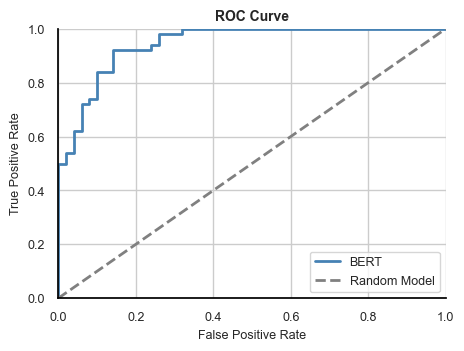

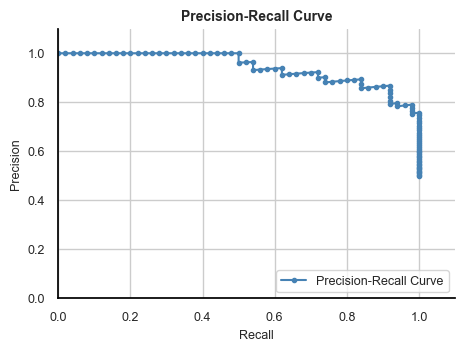

In [77]:
features_train = np.concatenate(embeddings_train)
features_test = np.concatenate(embeddings_test)

target_train = df_reviews.loc[random_train_reviews.index, 'pos']
target_test = df_reviews.loc[random_test_reviews.index, 'pos']

model_new = LogisticRegression(max_iter=100, random_state=42)
model_new.fit(features_train, target_train)

prediction_train = model_new.predict(features_train)
train_accuracy = f1_score(target_train, prediction_train)

prediction_test = model_new.predict(features_test)
test_accuracy = f1_score(target_test, prediction_test)

dump(model_new, 'logistic_regression_model.joblib')

print(f"F1 Score Train: {train_accuracy:.2f}")
print(f"F1 Score Test: {test_accuracy:.2f}")
print() 

probabilities_test = model_new.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1.0, 0.1):
    predictions_test_bert = (probabilities_one_test >= threshold)
    ps_bert = precision_score(target_test, predictions_test_bert)
    rs_bert = recall_score(target_test, predictions_test_bert)
    f1_bert = f1_score(target_test, predictions_test_bert)
    

    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}'.format(threshold, ps_bert, rs_bert, f1_bert))
   
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
precision, recall, thresholds_prc = precision_recall_curve(target_test, probabilities_one_test)

sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(fpr, tpr, label='BERT', color='steelblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5.12, 3.5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve', color='steelblue')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall', fontsize=9)
plt.ylabel('Precision', fontsize=9)
plt.title('Precision-Recall Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()



In [78]:
confidence = np.max(model_new.predict_proba(features_test), axis=1)
df_bert = pd.DataFrame(random_test_reviews, columns=['review'])
df_bert['prediction'] = prediction_test
df_bert['confidence'] = confidence
df_bert

,review,prediction,confidence
2,there is no real story the film seems more lik...,0,0.681373
3,um .... a serious film about troubled teens in...,1,0.972596
4,i'm totally agree with garryjohal from singapo...,1,0.632753
5,this is the first movie i've seen from singapo...,1,0.997679
6,yes non-singaporean's can't see what's the big...,1,0.891176
...,...,...,...
258,"dear readers, 2001: a space odyssey is kubrick...",1,0.996316
259,"""200l: a space odyssey"" is a supremely intrigu...",1,0.966250
260,no one can argue with it. this is and will be ...,1,0.727677
261,this was such a great film. it was done with s...,1,0.924863


The first model utilized was the BERT model. Since the original dataset included a column (ds_part) that organized the reviews into train and test sets, this was used to filter a sample of the first 100 train reviews and 100 test reviews for processing. To avoid overloading the system, the BERT model was run iteratively over these 100 reviews for both train and test sets, using a max_length of 512 and a batch_size of 50. This process generated two embeddings: one for the training features (features_train) and another for the test features (features_test).

For the corresponding targets, the pos column from the original dataset was used, ensuring the targets matched the indexes of the train and test sets. The logistic regression model, configured with a maximum of 100 iterations, was then trained on these embeddings.

The results showed an F1 score of 0.88 on the test set (compared to 1.00 on the train set), indicating slight overfitting. However, the test score exceeded the minimum threshold of 0.85, reflecting a strong performance overall. Additionally, the ROC and Precision-Recall curves indicate that the model is quite strong, performing well above a random baseline. Across various thresholds, it maintains a favorable balance between precision and recall. For example, at an F1 score of 0.88, the model achieves a precision of 0.865 and a recall of 0.9 (values closer to 1 are preferable).

---

#### Bag of Words Model

In [81]:
train_reviews = df_reviews[df_reviews['ds_part'] == 'train']
corpus_train = train_reviews['review']

test_reviews =  df_reviews[df_reviews['ds_part'] == 'test']
corpus_test = test_reviews['review']

In [97]:
stop_words = list(stopwords.words('english'))
count_vect = CountVectorizer(stop_words=stop_words)
bow_train = count_vect.fit_transform(corpus_train)
bow_test = count_vect.transform(corpus_test)

Best model: max_depth = 10, learning_rate = 0.01, num_trees: 50, F1 Score Train: 0.78, F1 Score Test: 0.78

Threshold = 0.00 | Precision = 0.498, Recall = 1.000, F1 = 0.665
Threshold = 0.10 | Precision = 0.498, Recall = 1.000, F1 = 0.665
Threshold = 0.20 | Precision = 0.500, Recall = 1.000, F1 = 0.667
Threshold = 0.30 | Precision = 0.540, Recall = 0.997, F1 = 0.700
Threshold = 0.40 | Precision = 0.615, Recall = 0.965, F1 = 0.751
Threshold = 0.50 | Precision = 0.710, Recall = 0.857, F1 = 0.777
Threshold = 0.60 | Precision = 0.890, Recall = 0.329, F1 = 0.480
Threshold = 0.70 | Precision = 0.977, Recall = 0.011, F1 = 0.021
Threshold = 0.80 | Precision = 0.000, Recall = 0.000, F1 = 0.000
Threshold = 0.90 | Precision = 0.000, Recall = 0.000, F1 = 0.000


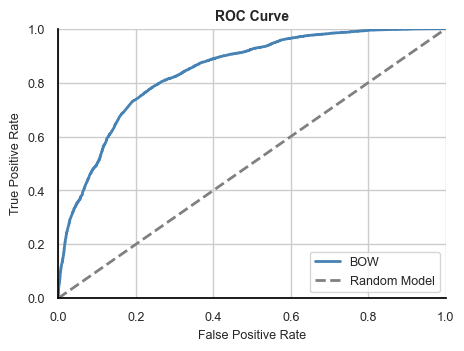

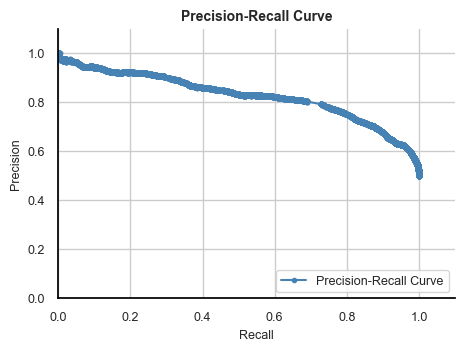

In [99]:
features_train = bow_train
features_test = bow_test

target_train = train_reviews['pos'].values 
target_test = test_reviews['pos'].values 

num_trees_range = [50]      
learning_rate_range = [0.01] 
max_depth_range = [10]         

best_score = 0
best_params = {}

for num_trees in num_trees_range:
    for learning_rate in learning_rate_range:
        for max_depth in max_depth_range:
            model_bow = CatBoostClassifier(iterations=num_trees, learning_rate=learning_rate, depth=max_depth,
                                      subsample= 0.8, random_seed=42, verbose=0, loss_function='Logloss', custom_metric=['F1'])
                      
            model_bow.fit(features_train, target_train, eval_set=(features_test, target_test), early_stopping_rounds=50)            
            predictions_train = model_bow.predict(features_train)
            prediction_test = model_bow.predict(features_test)         
                        
            train_accuracy = f1_score(target_train, predictions_train)
            test_accuracy = f1_score(target_test, prediction_test)
            
            if test_accuracy > best_score:
                best_score = test_accuracy
                best_params = {'num_trees': num_trees, 'learning_rate': learning_rate, 'max_depth': max_depth,
                               'F1 Score Train': train_accuracy, 'F1 Score Test': test_accuracy}

print(f"Best model: max_depth = {max_depth}, learning_rate = {learning_rate}, num_trees: {num_trees}, F1 Score Train: {train_accuracy:.2f}, F1 Score Test: {test_accuracy:.2f}")
print() 

probabilities_test = model_bow.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1.0, 0.1):
    predictions_test = (probabilities_one_test >= threshold)
    ps_bow = precision_score(target_test, predictions_test)
    rs_bow = recall_score(target_test, predictions_test)
    f1_bow = f1_score(target_test, predictions_test)
    

    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}'.format(threshold, ps_bow, rs_bow, f1_bow))
   
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
precision, recall, thresholds_prc = precision_recall_curve(target_test, probabilities_one_test)

sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(fpr, tpr, label='BOW', color='steelblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5.12, 3.5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve', color='steelblue')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall', fontsize=9)
plt.ylabel('Precision', fontsize=9)
plt.title('Precision-Recall Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [100]:
confidence = np.max(probabilities_test, axis=1)
df_bow = pd.DataFrame(corpus_test, columns=['review'])
df_bow['prediction'] = prediction_test
df_bow['confidence'] = confidence
df_bow

,review,prediction,confidence
2,there is no real story the film seems more lik...,1,0.501358
3,um .... a serious film about troubled teens in...,0,0.586890
4,i'm totally agree with garryjohal from singapo...,0,0.660276
5,this is the first movie i've seen from singapo...,1,0.605903
6,yes non-singaporean's can't see what's the big...,1,0.561142
...,...,...,...
47227,this is another of my favorite columbos. it sp...,1,0.686893
47228,talk about being boring! i got this expecting ...,0,0.551110
47229,"i never thought i'd say this about a biopic, b...",1,0.512386
47230,spirit and chaos is an artistic biopic of miya...,1,0.597017


The second model run utilized the Bag of Words approach. In this analysis, the data was first filtered by the ds_part column to separate the training and testing sets. The text data (corpus) was then prepared separately for both sets. To enhance the quality of the analysis, the stop_words functionality was applied to remove irrelevant or excessive words that do not contribute meaningful insights.

A count vectorizer was used to quantify the words in each review, generating inputs for the gradient boosting model. This classifier was configured with 50 trees, a learning rate of 0.01, and a maximum depth of 10. The resulting F1 score for both the training and testing sets was 0.78. Additionally, the ROC curve suggests the model is reasonably strong, outperforming a random baseline. Although it underperforms compared to the BERT model, it still maintains a reasonably favorable balance between precision and recall across different thresholds. For instance, at an F1 score of 0.78, it achieves a precision of 0.71 and a recall of 0.86 (where values closer to 1 are preferable).

---

#### TF-IDF Model

In [101]:
train_reviews = df_reviews[df_reviews['ds_part'] == 'train']
corpus_train = train_reviews['review']

test_reviews =  df_reviews[df_reviews['ds_part'] == 'test']
corpus_test = test_reviews['review']

In [103]:
stop_words = list(stopwords.words('english')) 
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

F1 Score Train: 0.94
F1 Score Test: 0.88

Threshold = 0.00 | Precision = 0.498, Recall = 1.000, F1 = 0.665
Threshold = 0.10 | Precision = 0.594, Recall = 0.998, F1 = 0.744
Threshold = 0.20 | Precision = 0.675, Recall = 0.989, F1 = 0.803
Threshold = 0.30 | Precision = 0.756, Recall = 0.973, F1 = 0.851
Threshold = 0.40 | Precision = 0.823, Recall = 0.940, F1 = 0.878
Threshold = 0.50 | Precision = 0.884, Recall = 0.881, F1 = 0.883
Threshold = 0.60 | Precision = 0.928, Recall = 0.794, F1 = 0.856
Threshold = 0.70 | Precision = 0.955, Recall = 0.661, F1 = 0.781
Threshold = 0.80 | Precision = 0.978, Recall = 0.473, F1 = 0.637
Threshold = 0.90 | Precision = 0.989, Recall = 0.222, F1 = 0.363


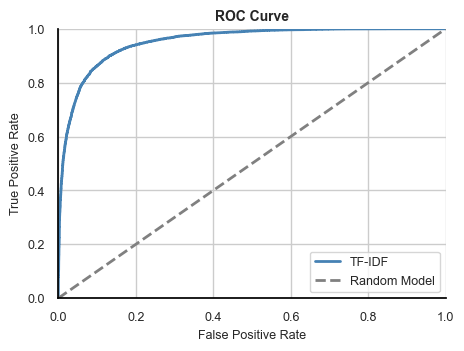

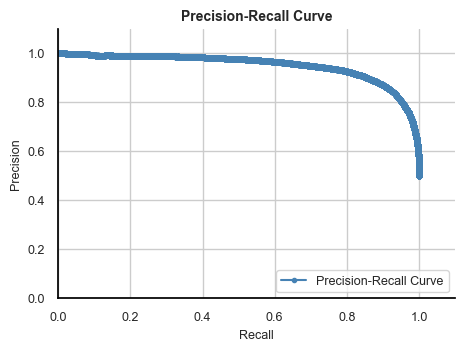

In [104]:
features_train = tf_idf_train
features_test = tf_idf_test

target_train = train_reviews['pos'].values 
target_test = test_reviews['pos'].values 

model_tf = LogisticRegression(max_iter=1000, random_state=42)
model_tf.fit(features_train, target_train)

prediction_train = model_tf.predict(features_train)
train_accuracy = f1_score(target_train, prediction_train)

prediction_test = model_tf.predict(features_test)
test_accuracy = f1_score(target_test, prediction_test)

print(f"F1 Score Train: {train_accuracy:.2f}")
print(f"F1 Score Test: {test_accuracy:.2f}")
print() 

probabilities_test = model_tf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1.0, 0.1):
    predictions_test = (probabilities_one_test >= threshold)
    ps_tf = precision_score(target_test, predictions_test)
    rs_tf = recall_score(target_test, predictions_test)
    f1_tf = f1_score(target_test, predictions_test)
    

    print('Threshold = {:.2f} | Precision = {:.3f}, Recall = {:.3f}, F1 = {:.3f}'.format(threshold, ps_tf, rs_tf, f1_tf))
   
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
precision, recall, thresholds_prc = precision_recall_curve(target_test, probabilities_one_test)

sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(fpr, tpr, label='TF-IDF', color='steelblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5.12, 3.5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve', color='steelblue')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall', fontsize=9)
plt.ylabel('Precision', fontsize=9)
plt.title('Precision-Recall Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [105]:
confidence = np.max(model_tf.predict_proba(features_test), axis=1)
df_tf = pd.DataFrame(corpus_test, columns=['review'])
df_tf['prediction'] = prediction_test
df_tf['confidence'] = confidence
df_tf

,review,prediction,confidence
2,there is no real story the film seems more lik...,0,0.594910
3,um .... a serious film about troubled teens in...,1,0.831490
4,i'm totally agree with garryjohal from singapo...,1,0.662658
5,this is the first movie i've seen from singapo...,1,0.876568
6,yes non-singaporean's can't see what's the big...,1,0.686487
...,...,...,...
47227,this is another of my favorite columbos. it sp...,1,0.940987
47228,talk about being boring! i got this expecting ...,0,0.882803
47229,"i never thought i'd say this about a biopic, b...",1,0.632945
47230,spirit and chaos is an artistic biopic of miya...,1,0.927353


The third and final model employed was the TF-IDF model. The preprocessing steps were similar to those used for the Bag of Words model. However, unlike the Bag of Words approach, which outputs word frequencies, the TF-IDF model assigns weights to words based on their importance in the reviews, giving higher weights to rarer words.

For this analysis, a Logistic Regression model was utilized. The F1 score achieved was 0.94 on the training set and 0.88 on the test set, indicating a low risk of overfitting. Additionally, these results surpassed the benchmark score of 0.85. Additionally, the ROC and Precision-Recall curves indicate that the model is quite strong, performing well above a random baseline. Across various thresholds, it maintains a favorable balance between precision and recall. For example, at an F1 score of 0.88, the model achieves a precision of 0.884 and a recall of 0.881 (values closer to 1 are preferable). 

---

#### Testing Own Reviews
---

In [106]:
new_reviews = [
    "the movie was absolutely stunning. the visuals, the acting, and the story were all top-notch!",
    "terrible acting, weak script, and a complete waste of time.",
    "an exceptional story with captivating performances. i would highly recommend it!",
    "this movie was boring and predictable. i wouldn’t recommend it.",
    "fantastic movie! the plot twists kept me on edge until the very end.",
    "the dialogue was laughable, and the acting was cringeworthy.",
    "a spectacular film with amazing cinematography. i loved every second of it!",
    "this movie was a chore to sit through. i wouldn’t recommend it to anyone.",
    "this movie hit all the right notes. emotional, gripping, and thoroughly enjoyable.",
    "it felt like the movie had no direction. completely pointless.",
    "absolutely loved it! the characters were well-written, and the direction was perfect.",
    "an absolute disaster. nothing about this movie worked.",
    "an incredible journey with a powerful message. highly recommended!",
    "the writing was lazy, and the acting was uninspired. a mess.",
    "this movie was pure art. every scene was a visual masterpiece.",
    "the plot holes were so big you could drive a truck through them.",
    "the humor in this movie was on point! i couldn’t stop laughing.",
    "horrible film. bad pacing, bad acting, and bad everything.",
    "a truly inspiring story. i feel like watching it again!",
    "nothing about this movie made sense. a complete waste of money.",
    "the action scenes were perfectly executed, and the pacing was just right.",
    "this movie was slow, boring, and had no redeeming qualities.",
    "this is what movies should be like—emotional, engaging, and beautiful.",
    "i don’t understand how this movie even got made. awful.",
    "a masterpiece! the soundtrack, visuals, and performances were impeccable.",
    "the story was all over the place, and the editing was awful.",
    "this film was pure entertainment. fun from start to finish.",
    "confusing plot, poorly developed characters, and bad direction.",
    "the acting was so authentic it felt like real life. what a movie!",
    "this movie was so bad i wanted to walk out halfway through.",
    "a delightful and uplifting movie that left me feeling great.",
    "an overhyped disaster. i regret wasting my time on this.",
    "this movie restored my faith in cinema. what a brilliant story!",
    "what a terrible experience. i feel robbed of two hours of my life.",
    "amazing cast, brilliant writing, and an unforgettable story. just perfect!",
    "this movie was awful. the pacing was off, and the story made no sense.",
    "the humor in this movie was just perfect!",
    "the visuals, soundtrack, and direction were incredible.",
    "this was a waste of time, with no redeeming qualities whatsoever.",
    "a thrilling and engaging movie experience that kept me hooked until the very last scene!"
]


actual_sentiments = [
    1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
    1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
    1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
    1, 0, 1, 0, 1, 0, 1, 0, 1, 1
]


In [107]:
# BERT 
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = BertConfig.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

max_length = 512
batch_size = 40

ids_list = []
attention_mask_list = []

for input_text in new_reviews:
    ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
    padded = np.array(ids + [0] * (max_length - len(ids)))
    attention_mask = np.where(padded != 0, 1, 0)
    ids_list.append(padded)
    attention_mask_list.append(attention_mask)

ids_array = np.array(ids_list)
attention_mask_array = np.array(attention_mask_list)

embeddings = []

for i in tqdm(range((len(ids_array) + batch_size - 1) // batch_size)):  
    ids_batch = torch.tensor(ids_array[batch_size * i : batch_size * (i + 1)], dtype=torch.long)
    attention_mask_batch = torch.tensor(attention_mask_array[batch_size * i : batch_size * (i + 1)], dtype=torch.long)
    with torch.no_grad():
        batch_embeddings = model(ids_batch, attention_mask=attention_mask_batch)
    embeddings.append(batch_embeddings[0][:, 0, :].numpy())
    



100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.79s/it]


F1 Score BERT: 0.87



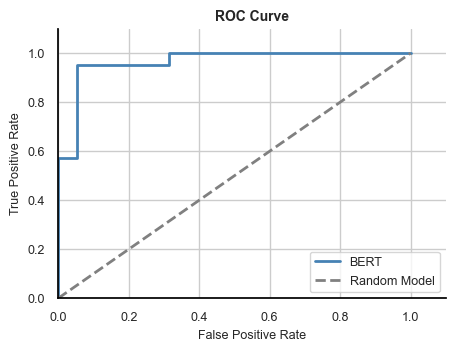

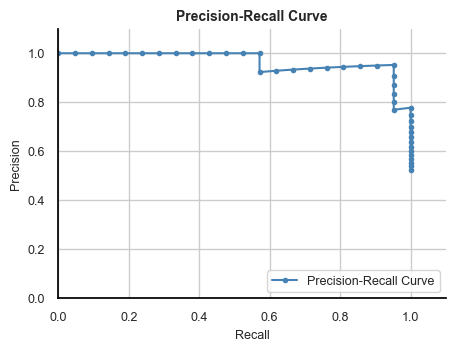

In [143]:
model_new = load('logistic_regression_model.joblib')
features_new = np.concatenate(embeddings)
prediction = model_new.predict(features_new)
f1_bert = f1_score(actual_sentiments, prediction)

print(f"F1 Score BERT: {f1_bert:.2f}")
print() 

probabilities_test = model_new.predict_proba(features_new)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1.0, 0.1):
    predictions_test_bert = (probabilities_one_test >= threshold)
    ps_bert = precision_score(actual_sentiments, prediction)
    rs_bert = recall_score(actual_sentiments, prediction)
    f1_bert = f1_score(actual_sentiments, prediction)
       
fpr, tpr, thresholds = roc_curve(actual_sentiments, probabilities_one_test)
precision, recall, thresholds_prc = precision_recall_curve(actual_sentiments, probabilities_one_test)

sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(fpr, tpr, label='BERT', color='steelblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve', color='steelblue')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall', fontsize=9)
plt.ylabel('Precision', fontsize=9)
plt.title('Precision-Recall Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [109]:
confidence = np.max(model_new.predict_proba(features_new), axis=1)
df_bert2 = pd.DataFrame(new_reviews, columns=['review'])
df_bert2['prediction'] = prediction
df_bert2['confidence'] = confidence
df_bert2.head(10)

,review,prediction,confidence
0,the movie was absolutely stunning. the visuals...,1,0.960097
1,"terrible acting, weak script, and a complete w...",0,0.993143
2,an exceptional story with captivating performa...,1,0.914501
3,this movie was boring and predictable. i would...,0,0.964105
4,fantastic movie! the plot twists kept me on ed...,1,0.534381
5,"the dialogue was laughable, and the acting was...",0,0.995343
6,a spectacular film with amazing cinematography...,1,0.941683
7,this movie was a chore to sit through. i would...,0,0.945373
8,"this movie hit all the right notes. emotional,...",1,0.971913
9,it felt like the movie had no direction. compl...,0,0.894707


F1 Score BOW: 0.82



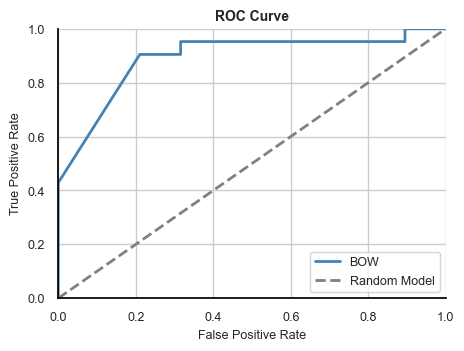

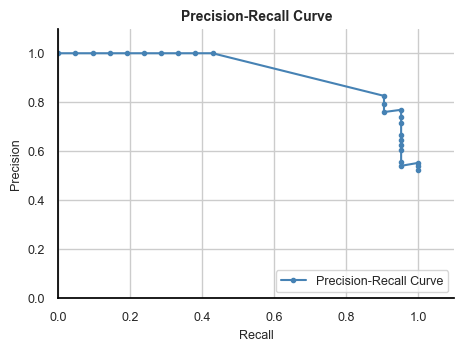

In [145]:
# Bag of Words
features_new = count_vect.transform(new_reviews)
predictions_new = model_bow.predict(features_new)
f1_bow = f1_score(actual_sentiments, predictions_new)
print(f"F1 Score BOW: {f1_bow:.2f}")
print() 

probabilities_test = model_bow.predict_proba(features_new)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1.0, 0.1):
    predictions_test_bow = (probabilities_one_test >= threshold)
    ps_bow = precision_score(actual_sentiments, predictions_new)
    rs_bow = recall_score(actual_sentiments, predictions_new)
    f1_bow = f1_score(actual_sentiments, predictions_new)
       
fpr, tpr, thresholds = roc_curve(actual_sentiments, probabilities_one_test)
precision, recall, thresholds_prc = precision_recall_curve(actual_sentiments, probabilities_one_test)

sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(fpr, tpr, label='BOW', color='steelblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5.11, 3.5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve', color='steelblue')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall', fontsize=9)
plt.ylabel('Precision', fontsize=9)
plt.title('Precision-Recall Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [117]:
confidence = np.max(model_bow.predict_proba(features_new), axis=1)
df_bow2 = pd.DataFrame(new_reviews, columns=['review'])
df_bow2['prediction'] = predictions_new
df_bow2['confidence'] = confidence
df_bow2.head(10)

,review,prediction,confidence
0,the movie was absolutely stunning. the visuals...,1,0.533965
1,"terrible acting, weak script, and a complete w...",0,0.675560
2,an exceptional story with captivating performa...,1,0.535557
3,this movie was boring and predictable. i would...,0,0.522350
4,fantastic movie! the plot twists kept me on ed...,1,0.524457
5,"the dialogue was laughable, and the acting was...",1,0.529827
6,a spectacular film with amazing cinematography...,1,0.536384
7,this movie was a chore to sit through. i would...,1,0.533965
8,"this movie hit all the right notes. emotional,...",1,0.533965
9,it felt like the movie had no direction. compl...,1,0.528025


F1 Score TF-IDF: 0.93



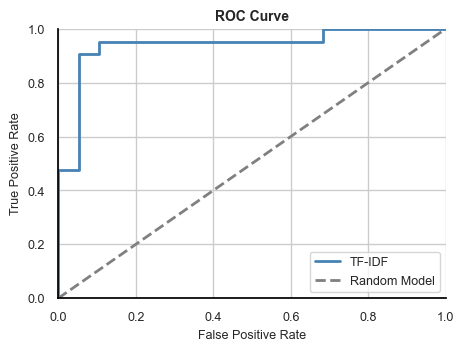

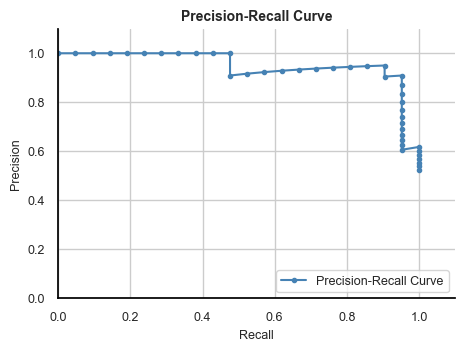

In [118]:
# TF-IDF
features_new = count_tf_idf.transform(new_reviews)
predictions_new = model_tf.predict(features_new)
f1_tf = f1_score(actual_sentiments, predictions_new)
print(f"F1 Score TF-IDF: {f1_tf:.2f}")
print() 

probabilities_test = model_tf.predict_proba(features_new)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 1.0, 0.1):
    predictions_test_tf = (probabilities_one_test >= threshold)
    ps_tf = precision_score(actual_sentiments, predictions_new)
    rs_tf = recall_score(actual_sentiments, predictions_new)
    f1_tf = f1_score(actual_sentiments, predictions_new)
       
fpr, tpr, thresholds = roc_curve(actual_sentiments, probabilities_one_test)
precision, recall, thresholds_prc = precision_recall_curve(actual_sentiments, probabilities_one_test)

sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5, 3.5))
plt.plot(fpr, tpr, label='TF-IDF', color='steelblue', lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Model', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=9)
plt.ylabel('True Positive Rate', fontsize=9)
plt.title('ROC Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


sns.set_theme(style="whitegrid", palette="Blues")
plt.figure(figsize=(5.12, 3.5))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve', color='steelblue')
plt.xlim([0.0, 1.1])
plt.ylim([0.0, 1.1])
plt.xlabel('Recall', fontsize=9)
plt.ylabel('Precision', fontsize=9)
plt.title('Precision-Recall Curve', fontsize=10, fontweight='bold')
plt.legend(loc='lower right', fontsize=9)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [119]:
confidence = np.max(model_tf.predict_proba(features_new), axis=1)
df_tf2 = pd.DataFrame(new_reviews, columns=['review'])
df_tf2['prediction'] = predictions_new
df_tf2['confidence'] = confidence
df_tf2.head(10)

,review,prediction,confidence
0,the movie was absolutely stunning. the visuals...,1,0.756315
1,"terrible acting, weak script, and a complete w...",0,0.999664
2,an exceptional story with captivating performa...,1,0.946435
3,this movie was boring and predictable. i would...,0,0.980597
4,fantastic movie! the plot twists kept me on ed...,1,0.824939
5,"the dialogue was laughable, and the acting was...",0,0.894894
6,a spectacular film with amazing cinematography...,1,0.972549
7,this movie was a chore to sit through. i would...,1,0.516405
8,"this movie hit all the right notes. emotional,...",1,0.938267
9,it felt like the movie had no direction. compl...,0,0.967814



### Conclusion

---
The analysis further evaluated all three models using a set of newly created reviews, referred to as new_reviews. This dataset consisted of 40 reviews—20 positive and 20 negative—designed with varying word weights and frequencies. The same models used during training and testing were applied to this new dataset, and their outputs were compared against the actual polarity of each review.

All 40 reviews were analyzed, and the results revealed that the TF-IDF model performed the best, achieving an F1 score of 0.93. It was followed by the BERT model with an F1 score of 0.87 and the Bag of Words (BOW) model with 0.82. Interestingly, the TF-IDF model slightly outperformed the BERT model in this step, compared to their equal performance during testing (both scoring 0.88). Meanwhile, the BOW model consistently underperformed, scoring 0.82 on the new review dataset and 0.78 during the testing phase. Below are the F1 score results:

Notably, both the BERT and TF-IDF models demonstrated strong performance across varying thresholds, as reflected by their ROC curves. Although the TF-IDF model achieved a marginally higher F1 score compared to BERT, the latter displayed a slightly better balance between precision and recall (with superior precision overall). Conversely, the BOW model exhibited comparatively weaker performance on both the ROC and PRC curves.

The variation in scores can also be attributed to the differing methodologies and datasets utilized by each model. For instance, in the BERT model analysis, only 100 training and 100 testing reviews were used due to the significant computational requirements, which is substantially less than the full dataset. Despite this limitation, BERT is generally considered more robust than the other two models because it captures the context of words within reviews when generating embeddings.

In contrast, the TF-IDF and Bag of Words (BOW) models operate differently. TF-IDF assigns relevance based on word weights, giving higher importance to less frequent words in reviews. Meanwhile, the BOW model determines polarity by focusing solely on word frequency. Both models used the full dataset in their analysis, which may have contributed to the TF-IDF model outperforming BERT in the testing phase. 

The variation in scores can also depend on the type of reviews being analyzed and how well they align with the strengths or weaknesses of each model - reviews that align with BERT’s ability to understand context might show stronger performance, whereas TF-IDF or BOW could excel with reviews where word importance or frequency is more indicative of sentiment.

In summary, the choice of model can depend on the specific task and the nature of the dataset. The BOW model is suitable for simpler classification tasks, TF-IDF works well for tasks that require weighting word importance, and BERT is the most robust for capturing context, albeit at a higher computational cost. Understanding the alignment between the review characteristics and the model’s strengths is key to optimizing performance.

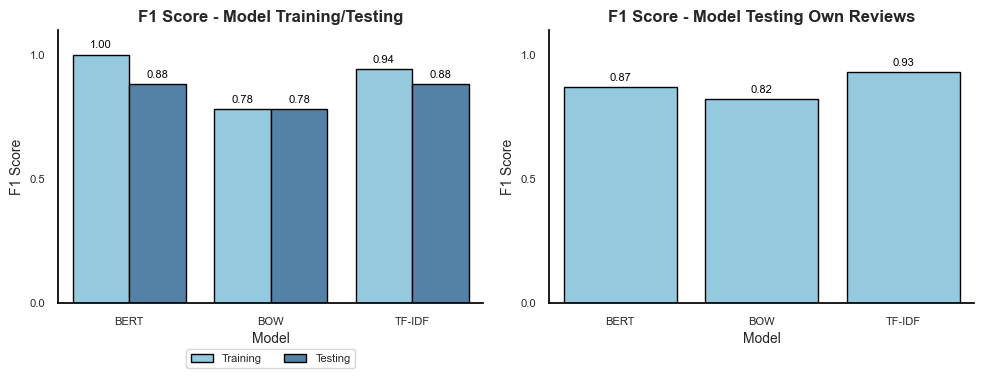

In [141]:
data_train_test = pd.DataFrame({
    'Model': ['BERT', 'BERT', 'BOW', 'BOW', 'TF-IDF', 'TF-IDF'],
    'F1_Score': [1.00, 0.88, 0.78, 0.78, 0.94, 0.88],
    'Dataset': ['Training', 'Testing', 'Training', 'Testing', 'Training', 'Testing']})


data_own_reviews = pd.DataFrame({
    'Model': ['BERT', 'BOW', 'TF-IDF'],
    'F1_Score': [0.87, 0.82, 0.93]})

sns.set_theme(style="white")

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

ax0 = axs[0]
sns.barplot(
    data=data_train_test, 
    x='Model', y='F1_Score', hue='Dataset', 
    ax=ax0, 
    palette={'Training': 'skyblue', 'Testing': 'steelblue'}, 
    edgecolor='black')
ax0.set_title('F1 Score - Model Training/Testing', fontweight='bold', fontsize=12)
ax0.set_xlabel('Model', fontsize=10)
ax0.set_ylabel('F1 Score', fontsize=10)
ax0.set_ylim(0, 1.1)

ax0.set_yticks([0, 0.5, 1.0])
ax0.tick_params(axis='x', labelsize=8)
ax0.tick_params(axis='y', labelsize=8)

ax0.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=8, title_fontsize=8)

ax0.grid(False)

for spine in ['top', 'right']:
    ax0.spines[spine].set_visible(False)
ax0.spines['bottom'].set_color('black')
ax0.spines['left'].set_color('black')

for p in ax0.patches:
    p.set_edgecolor('black')
    height = p.get_height()
    if height != 0:
        ax0.text(
            p.get_x() + p.get_width() / 2, 
            height + 0.02, 
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=8, color='black')

ax1 = axs[1]
sns.barplot(
    data=data_own_reviews, 
    x='Model', y='F1_Score', 
    ax=ax1, 
    color='skyblue', 
    edgecolor='black')
ax1.set_title('F1 Score - Model Testing Own Reviews', fontweight='bold', fontsize=12)
ax1.set_xlabel('Model', fontsize=10)
ax1.set_ylabel('F1 Score', fontsize=10)
ax1.set_ylim(0, 1.1)

ax1.set_yticks([0, 0.5, 1.0])
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)

ax1.grid(False)

for spine in ['top', 'right']:
    ax1.spines[spine].set_visible(False)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_color('black')

for p in ax1.patches:
    p.set_edgecolor('black')
    height = p.get_height()
    if height != 0:
        ax1.text(
            p.get_x() + p.get_width() / 2, 
            height + 0.02, 
            f'{height:.2f}',
            ha='center', va='bottom', fontsize=8, color='black')

plt.tight_layout()
plt.show()
